## Imports

In [1]:
import numpy as np
import pandas as pd
import pylab as pl
import os
from IPython.display import clear_output
from tqdm.notebook import trange

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

from utils import *
from document_cleaner import *

## Load data

### From kaggle

In [2]:
# from kaggle.api.kaggle_api_extended import KaggleApi
# import json
  
# with open('kaggle.json') as f:
#     data = json.load(f)

# os.environ['KAGGLE_USERNAME'] = data["username"]
# os.environ['KAGGLE_KEY'] = data["key"]

# api = KaggleApi()
# api.authenticate()

In [3]:
# api.dataset_download_files('rmisra/news-category-dataset', path="./data", unzip=True)

### From disk

In [4]:
data = pd.read_json("data/News_Category_Dataset_v2.json", lines=True)

In [5]:
data["full_text"] = data["headline"] + ". " + data["short_description"]

## Data exploration/cleaning

In [6]:
data.loc[data["category"] == "THE WORLDPOST", "category"]= "WORLDPOST"

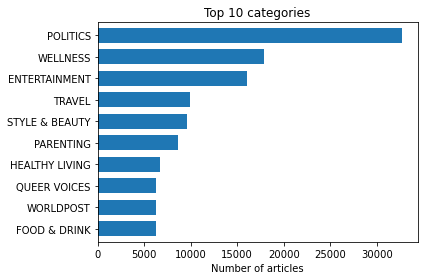

In [7]:
data["category"].value_counts()[:10][::-1].plot.barh(title="Top 10 categories", width=0.7)
pl.xlabel('Number of articles')
pl.savefig("top_10_categories.png", dpi=200)

In [8]:
data["date"].min(), data["date"].max()

(Timestamp('2012-01-28 00:00:00'), Timestamp('2018-05-26 00:00:00'))

In [9]:
documents, labels = data["full_text"].to_numpy(), data["category"].to_numpy()

In [10]:
cleaner = DocumentCleaner()
cleaned_documents = cleaner.clean(documents)
cleaned_documents = remove_short_words(cleaned_documents, min_length=2)

### Collocations

In [11]:
collocations = find_collocations(cleaned_documents)
collocations.head(10)

,bigram,pmi
0,"(donald, trump)",2047.863099
1,"(hillari, clinton)",1054.000462
2,"(berni, sander)",534.781150
3,"(new, york)",501.561828
4,"(suprem, court)",457.214420
5,"(los, angel)",351.713647
6,"(ted, cruz)",271.381164
7,"(taylor, swift)",262.431148
8,"(tumblr, pinterest)",253.041254
9,"(marco, rubio)",224.848895


In [12]:
set_collocations = collocations.sort_values(by='pmi', ascending=False).head(1000)["bigram"].to_list()

In [13]:
cleaned_documents = apply_collocations(cleaned_documents, set_collocations)

Documents processed:   0%|          | 0/200853 [00:00<?, ?it/s]

In [14]:
data["full_text_cleaned"] = cleaned_documents

### Word cloud

In [16]:
from wordcloud import WordCloud

In [17]:
%matplotlib qt
text = ' '.join(documents_to_words(cleaned_documents))
wordcloud = WordCloud(max_font_size=160, width=1600, height=800, colormap=pl.get_cmap("viridis"), background_color="white").generate(text)
pl.imshow(wordcloud, interpolation="bilinear")
pl.axis("off")
pl.show()
pl.savefig("wordcloud.png", dpi=200)

### T-SNE

In [41]:
# filter data to the 10most probable classes
data_filtered = data[data.category.isin(data.category.value_counts().head(10).index)]
X, y = data_filtered["full_text_cleaned"].to_numpy(), data_filtered["category"].to_numpy()

# shuffle data
perm = np.random.permutation(X.shape[0])
X = X[perm]
y = y[perm]

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(y)
y = le.transform(y)

X = TfidfVectorizer(ngram_range=(1, 1),
                    stop_words='english',
                    analyzer='word',
                    min_df=0.001,
                    max_df=0.7,
                    sublinear_tf=True,
                    use_idf=True).fit_transform(X)


In [47]:
import numpy as np
from sklearn.manifold import TSNE

n_samples = 5000

X_embedded = TSNE(n_components=2, verbose=1).fit_transform(X[:n_samples].astype(np.float32))
clear_output()

/tmp/ipykernel_7797/4090333547.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


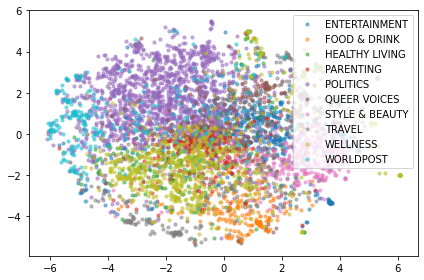

In [46]:
group = y[:n_samples]

fig, ax = pl.subplots()
for g in np.unique(group):
    ax.scatter(X_embedded[group==g, 0], X_embedded[group==g, 1], label=le.classes_[g], s=10, alpha=0.5, color=pl.cm.get_cmap("tab10")(g))
ax.legend()
fig.show()

## Topic modeling

### SVD/NMF

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), 
                                   stop_words='english', 
                                   analyzer='word', 
                                   min_df=0.001, 
                                   max_df=0.7, 
                                   sublinear_tf=True, 
                                   use_idf=True)

X = tfidf_vectorizer.fit_transform(cleaned_documents)

In [49]:
from sklearn.decomposition import TruncatedSVD
# set number of latent components
k = 5

svd = TruncatedSVD(n_components=k)
U = svd.fit_transform(X)
S = svd.singular_values_
V = svd.components_

In [23]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=k, init='nndsvd', random_state=0)

W = nmf.fit_transform(X)
H = nmf.components_

In [56]:
terms = tfidf_vectorizer.get_feature_names()

show_topics(V, terms)

['make, new, time, photo, day',
 'trump, donald_trump, presid, say, republican',
 'photo, 0000, look, week, new',
 'new, 0000, year, world, time',
 'new, make, photo, trump, video']

### sklearn LDA

In [61]:
# shuffle data
X = data["full_text_cleaned"].to_numpy()
perm = np.random.permutation(X.shape[0])
X = X[perm]

In [62]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,1), 
                                   stop_words='english', 
                                   analyzer='word', 
                                   min_df=50, 
                                   max_df=0.5,
                                   sublinear_tf=True).fit(X)

X = vectorizer.transform(X)
lda = LatentDirichletAllocation(n_components=5, random_state=0,verbose=1)
lda.fit(X[:10000])

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(n_components=5, random_state=0, verbose=1)

In [63]:
tokens = [np.argsort(component)[-5:] for component in lda.components_]
for token in tokens:
    print([vectorizer.get_feature_names()[i] for i in token])

['0000', 'peopl', 'say', 'way', 'polic']
['life', 'say', 'donald_trump', 'new', 'trump']
['video', 'year', 'say', '0000', 'new']
['like', 'day', 'time', 'make', 'thing']
['dress', '0000', 'wed', 'new', 'photo']


### gensim LDA

In [137]:
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary

instances = data["full_text_cleaned"].apply(str.split)

#instances = instances.sample(25000, replace=False)

dictionary = Dictionary(instances)
dictionary.filter_extremes(no_below=100, no_above=0.3)

In [138]:
ldacorpus = [dictionary.doc2bow(text) for text in instances]
tfidfmodel = TfidfModel(ldacorpus)
model_corpus = tfidfmodel[ldacorpus]

#### Umass/CV score

In [131]:
coherence_values = []

dev_size = 20000
eval_size = 5000

for num_topics in trange(4, 10):
    model = LdaMulticore(corpus=model_corpus[:dev_size], 
                         id2word=dictionary, 
                         num_topics=num_topics,
                         workers=4,
                         alpha="symmetric",
                         eta="symmetric",
                         passes=10)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=instances[dev_size:dev_size+eval_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=instances[dev_size:dev_size+eval_size], 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    coherence_values.append((num_topics, umass_score, cv_score))

  0%|          | 0/6 [00:00<?, ?it/s]

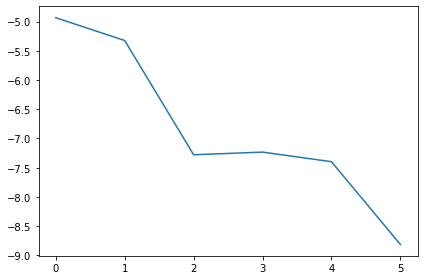

In [136]:
pl.plot(np.array(coherence_values)[:, 1])

#### Model

In [139]:
model = LdaMulticore(corpus=model_corpus, 
                         id2word=dictionary, 
                         num_topics=4,
                         passes=10,
                         alpha="symmetric",
                         eta="symmetric",
                         workers=4)

In [173]:
def get_topic_descriptors(lda_model, num_words=3):
    descriptors = []
    for topic in lda_model.print_topics(num_words=num_words):
        topic_words = []
        for word in topic[1].split("+"):
            topic_words.append(re.sub(r"0\.[0-9]+\*", '',word).replace('"', '').strip())

        descriptors.append(", ".join(topic_words))

    return descriptors

descriptors = get_topic_descriptors(model, num_words=2)

In [141]:
topic_corpus = np.array(model[model_corpus])

In [175]:
topic_distros = pd.DataFrame(data=topic_corpus[:, :, 1], columns=descriptors)
topic_distros["category"] = data["category"]
topic_distros["date"] = data["date"]

In [176]:
most_common_categories = topic_distros.groupby("category").count().sort_values(by="date", ascending=False).index.values

In [199]:
%matplotlib inline

<AxesSubplot:ylabel='category'>

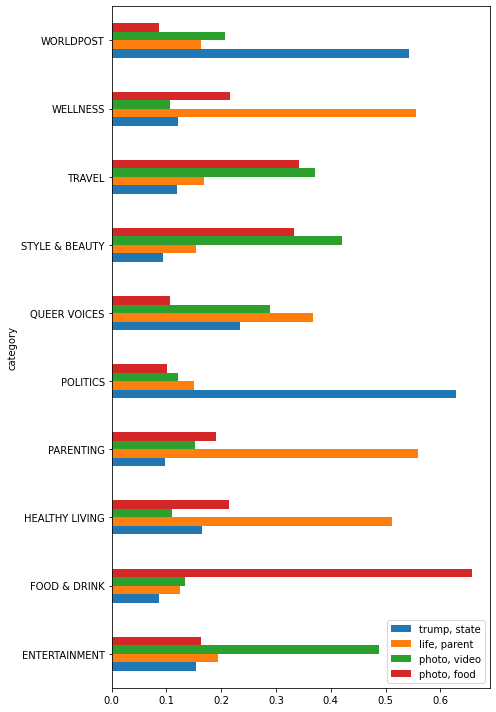

In [200]:
topic_distros[topic_distros["category"].isin(most_common_categories[:10])].groupby("category").mean().plot.barh(figsize=(7, 10))

<AxesSubplot:xlabel='date'>

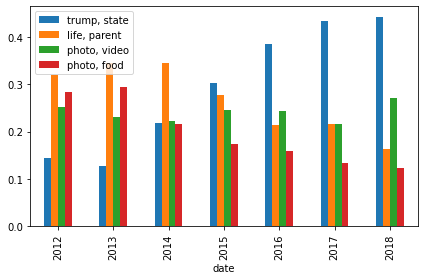

In [201]:
topic_distros.groupby(topic_distros.date.dt.year).mean().plot(kind='bar')

## Doc2Vec

In [42]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import FAST_VERSION
from gensim.models.doc2vec import TaggedDocument

corpus = []

for document, label in zip(data["full_text_cleaned"], data["category"]):
    corpus.append(TaggedDocument(words=document.split(), tags=[label]))

d2v_model = Doc2Vec(vector_size=100,
                    hs=0,
                    sample=1e-4,
                    negative=5,
                    min_count=100,
                    workers=-1,
                    epochs=100,
                    dm=0, 
                    dbow_words=1)
d2v_model.build_vocab(corpus)
d2v_model.train(corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

In [47]:
label = "ENTERTAINMENT"
d2v_model.dv.most_similar(str(label), topn=5)

[('WELLNESS', 0.18336938321590424),
 ('HOME & LIVING', 0.17054887115955353),
 ('CRIME', 0.162625253200531),
 ('IMPACT', 0.15600277483463287),
 ('LATINO VOICES', 0.13687974214553833)]

# Naive Bayes

In [24]:
# Encode y labels
from sklearn.preprocessing import LabelEncoder
y = LabelEncoder().fit_transform(y)

In [7]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [47]:
# Tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(lowercase=True, min_df=0.0001, max_df=0.7, sublinear_tf=True, strip_accents="unicode", ngram_range=(1,2))

In [10]:
# Count vectorizer
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(lowercase=True, min_df=0.0001, max_df=0.7, strip_accents="unicode", ngram_range=(1,2), stop_words="english")

In [ ]:
# logreg
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=4, max_iter=1000, solver="saga", verbose=1, tol=0.1)

In [8]:
# naive bayes
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

In [11]:
# Pipeline
from sklearn.pipeline import Pipeline
pipe = Pipeline([('vectorizer', count_vectorizer), ('model', mnb)])
pipe.fit(X_train, y_train)

pipe.score(X_test, y_test)

0.5803689228547958

In [12]:
# logloss
from sklearn.metrics import log_loss
log_loss(y_test, pipe.predict_proba(X_test))

2.5405328479547586

# CNN

In [5]:
import torch
from torch import nn
from torch.nn import functional as F
from CNN import *
from tokenizer import *

In [10]:
X = np.load("data/X_news_category_cleaned.npy", allow_pickle=True)
tokenizer = MyTokenizer(max_length=256)
tokenizer.fit(X)

In [8]:
data = pd.read_json("data/News_Category_Dataset_v2.json", lines=True)
y = data["category"].values
# Encode y labels
from sklearn.preprocessing import LabelEncoder
y = LabelEncoder().fit_transform(y)

y = torch.from_numpy(y).long()

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(torch.tensor(tokenizer.transform(X)), y, test_size=0.7)

In [12]:
import torch
from torch.utils.data import Dataset


class MatrixLoader(Dataset):
    """Simple dataloader given the data matrix X and response y
    batch is assumed to be the first dimension"""
    def __init__(self, X, y, classification=True):
        self.X = X
        self.y = y

        if classification:
            self.y = self.y.to(int)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [13]:
# Create datasets
train_set= MatrixLoader(X_train, y_train)
test_set = MatrixLoader(X_test, y_test)

# Create dataloaders
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=True)

In [14]:
from CNN import *
net = CNN(embedding_dim=64, n_resnets=5, blocks_per_resnet=1, kernel_size=3)

model = TextClassifier(tokenizer.get_vocab_size(), embedding_dim=64, out_dim=y.max()+1, net=net)

In [ ]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-2)
criterion = nn.CrossEntropyLoss()

losses = []
for epoch in range(10):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().item())
        print(batch_idx, loss.cpu().item())

        if batch_idx % 10 == 0:
            clear_output(True)
            pl.plot(losses)


    # Print eval loss
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()

        test_loss /= batch_idx + 1
        print(f"Test loss: {test_loss}")